In [1]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers  import l2 
from keras import backend as K
from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

Using TensorFlow backend.


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Import libraries for data wrangling, preprocessing and visualization
import numpy 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
# Importing libraries for building the neural network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

In [3]:
schema = {
    'sample':               str,
    'tumor type':              str,
    'PVR'      :           np.float64,
    'IL10RB'  :             np.float64,
    'IL22RA1' :             np.float64,
    'IL22RA2'  :            np.float64,
    'IL22':                 np.float64,
    'OS.time'   :          np.float64,
    'OS'       :           str,
    'pathologic_stage'  :   str
}

In [4]:
data = pd.read_csv('../data/TCGA_data_IL-22_gene_signature.csv', sep=';', decimal=",", na_values=('na',), dtype=schema)
data = data.dropna()

In [5]:
data.head(2)

,sample,tumor type,PVR,IL10RB,IL22RA1,IL22RA2,IL22,OS.time,OS,pathologic_stage
7,TCGA-S5-A6DX,BLCA (BLADDER),11.91,10.15,6.001,2.689,0.8304,56.0,1,Stage IV
18,TCGA-GU-A766,BLCA (BLADDER),11.36,10.45,7.823,2.742,3.7750,480.0,0,Stage II


In [6]:
data.describe(include='all')

,sample,tumor type,PVR,IL10RB,IL22RA1,IL22RA2,IL22,OS.time,OS,pathologic_stage
count,737,737,737.000000,737.000000,737.000000,737.000000,737.000000,737.000000,737,737
unique,726,13,NaN,NaN,NaN,NaN,NaN,NaN,2,20
top,TCGA-KP-A3W1,HNSC (HEAD AND NECK),NaN,NaN,NaN,NaN,NaN,NaN,0,Stage IVA
freq,2,147,NaN,NaN,NaN,NaN,NaN,NaN,492,85
mean,NaN,NaN,10.405282,10.063114,7.903316,3.170843,1.119251,894.746269,NaN,NaN
std,NaN,NaN,0.786878,0.522410,2.203234,1.737911,0.966700,815.515736,NaN,NaN
min,NaN,NaN,7.601000,8.242000,0.000000,0.313500,0.275400,0.000000,NaN,NaN
25%,NaN,NaN,9.948000,9.736000,6.645000,1.858000,0.512500,358.000000,NaN,NaN
50%,NaN,NaN,10.410000,10.100000,8.247000,2.993000,0.737800,641.000000,NaN,NaN
75%,NaN,NaN,10.910000,10.380000,9.607000,4.287000,1.315000,1163.000000,NaN,NaN


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 737 entries, 7 to 4844
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   sample            737 non-null    object 
 1   tumor type        737 non-null    object 
 2   PVR               737 non-null    float64
 3   IL10RB            737 non-null    float64
 4   IL22RA1           737 non-null    float64
 5   IL22RA2           737 non-null    float64
 6   IL22              737 non-null    float64
 7   OS.time           737 non-null    float64
 8   OS                737 non-null    object 
 9   pathologic_stage  737 non-null    object 
dtypes: float64(6), object(4)
memory usage: 63.3+ KB


In [8]:
# Convert Pathologica stages into labels
Z = data.pathologic_stage.values
encoder_ps = LabelEncoder()
encoder_ps.fit(Z)
encoded_ps = encoder_ps.transform(Z)
encoder_ps.classes_

array(['G2', 'G3', 'Stage I', 'Stage IA', 'Stage IB', 'Stage IB1',
       'Stage IB2', 'Stage II', 'Stage IIA', 'Stage IIA1', 'Stage IIB',
       'Stage IIC', 'Stage III', 'Stage IIIA', 'Stage IIIB', 'Stage IIIC',
       'Stage IV', 'Stage IVA', 'Stage IVB', '[Discrepancy]'],
      dtype=object)

In [9]:
# Convert tumor type into labels
R = data['tumor type'].values
encoder_tt = LabelEncoder()
encoder_tt.fit(R)
encoded_tt = encoder_tt.transform(R)
encoder_tt.classes_

array(['BLCA (BLADDER)', 'CESC ( CERVICAL CANCER)',
       'COADREAD (COLON AND RECTAL)', 'GLIOMA (GBMLGG)',
       'HNSC (HEAD AND NECK)', 'KIRC (KIDNEY CLEAR CELL CARCINOMA)',
       'LIHC (LIVER CANCER)', 'LUAD (LUNG ADENOCARCINOMA)',
       'LUSC (LUNG SQUAMOUS)', 'PAAD (PANCREATIC)', 'STAD (STOMACH)',
       'TNBC (TRIPLE NEG. BREAST)', 'UCEC (ENDOMETRIOID)'], dtype=object)

In [10]:
data.columns

Index(['sample', 'tumor type', 'PVR', 'IL10RB', 'IL22RA1', 'IL22RA2', 'IL22',
       'OS.time', 'OS', 'pathologic_stage'],
      dtype='object')

In [11]:
prediction_var = ['IL22', 'IL22RA1', 'IL10RB', 'IL22RA2', 'PVR', 'OS.time', 'tumor type', 'pathologic_stage']
data.pathologic_stage = encoded_ps
data['tumor type'] = encoded_tt

In [12]:
X = data[prediction_var].values
X

array([[8.304e-01, 6.001e+00, 1.015e+01, ..., 5.600e+01, 0.000e+00,
        1.600e+01],
       [3.775e+00, 7.823e+00, 1.045e+01, ..., 4.800e+02, 0.000e+00,
        7.000e+00],
       [1.398e+00, 7.556e+00, 9.648e+00, ..., 3.210e+02, 0.000e+00,
        1.200e+01],
       ...,
       [6.231e-01, 2.679e+00, 9.390e+00, ..., 6.660e+02, 1.200e+01,
        1.800e+01],
       [1.118e+00, 2.174e+00, 9.217e+00, ..., 2.185e+03, 1.200e+01,
        7.000e+00],
       [5.773e-01, 6.585e+00, 8.807e+00, ..., 1.014e+03, 1.200e+01,
        7.000e+00]])

In [13]:
#Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
data_new = sc.fit_transform(data[prediction_var])
X = data_new
X

array([[-2.99003872e-01, -8.64006345e-01,  1.66430677e-01, ...,
        -1.02918416e+00, -1.52516748e+00,  1.20450117e+00],
       [ 2.74909761e+00, -3.64785109e-02,  7.41082393e-01, ...,
        -5.08914680e-01, -1.52516748e+00, -5.34605549e-01],
       [ 2.88547036e-01, -1.57746311e-01, -7.95153195e-01, ...,
        -7.04015734e-01, -1.52516748e+00,  4.31564852e-01],
       ...,
       [-5.13590383e-01, -2.37281395e+00, -1.28935367e+00, ...,
        -2.80683259e-01,  1.88793504e+00,  1.59096933e+00],
       [-1.29484994e-03, -2.60217815e+00, -1.62073616e+00, ...,
         1.58320669e+00,  1.88793504e+00, -5.34605549e-01],
       [-5.61000234e-01, -5.98761419e-01, -2.40609351e+00, ...,
         1.46330369e-01,  1.88793504e+00, -5.34605549e-01]])

In [14]:
Y = data.OS.values
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
encoder.classes_

array(['0', '1'], dtype=object)

In [15]:
#standardizing the input feature
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, encoded_Y, test_size=0.1, shuffle=True, random_state=543)

In [16]:
# !pip install git+https://github.com/tensorflow/docs
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

# Baseline model for the neural network. We choose a hidden layer of 10 neurons. The lesser number of neurons helps to eliminate the redundancies in the data and select the more important features.
def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(24, input_dim=8, kernel_regularizer=l2(0.01), activation='relu'))
    model.add(Dropout(0.3, noise_shape=None, seed=None))
    model.add(Dense(12, kernel_regularizer=l2(0.01), activation='relu'))
    model.add(Dropout(0.3, noise_shape=None, seed=None))
    model.add(Dense(1,  activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    return model


In [17]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
# class_weights = np.array([0.001, 100.])
class_weights = {i : class_weights[i] for i in range(len(class_weights))}

In [22]:
classifier = create_baseline()
history = classifier.fit(X_train,y_train, batch_size=10, epochs=200, verbose=0, callbacks=[tfdocs.modeling.EpochDots()],
                         shuffle=True,
                         validation_data=(X_test,y_test),
                         class_weight=class_weights,
                        )


Epoch: 0, acc:0.5581,  loss:1.0008,  val_acc:0.6216,  val_loss:0.9212,  
....................................................................................................
Epoch: 100, acc:0.6667,  loss:0.6499,  val_acc:0.6622,  val_loss:0.6754,  
....................................................................................................

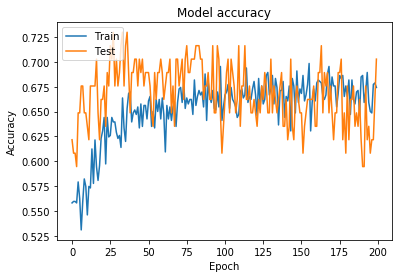

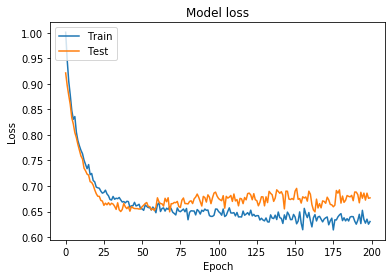

In [23]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [24]:
# z = data.sample()
# print(z.OS)
# print(z[prediction_var].values)
# # print(encoder_pd.transform(z._primary_disease))
# # z._primary_disease = encoder_pd.transform(z._primary_disease)
# # print(z[prediction_var].values)

# # encoder_pd.transform
# int(classifier.predict(z[prediction_var].values)[0])>0.5

In [25]:
#model
y_pred=classifier.predict(X_test)
y_pred = (y_pred>0.5)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print("### Model ###")
print(cm)
print(f'Accuracy: {(cm[0][0]+cm[1][1])/len(X_test)*100:.2f}%')

# All Dead
y_pred=np.zeros((len(X_test),1),dtype=np.ndarray)
y_pred =(y_pred>0.5)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print()
print("### Assuming that *every* patient is dead ###")
print(cm)
print(f'Accuracy: {(cm[0][0]+cm[1][1])/len(X_test)*100:.2f}%')
      
# All Random
y_pred=np.random.rand(len(X_test),1)
y_pred =(y_pred>0.5)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print()
print("### Assi ###")
print(cm)
print(f'Accuracy: {(cm[0][0]+cm[1][1])/len(X_test)*100:.2f}%')

### Model ###
[[34 16]
 [ 6 18]]
Accuracy: 70.27%

### All my friends are DEAD ###
[[50  0]
 [24  0]]
Accuracy: 67.57%

### All my friends are RANDOM ###
[[29 21]
 [11 13]]
Accuracy: 56.76%
